## Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.metrics import f1_score

## Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

# Read from drive
#df = pd.read_csv('./temp/Airline.csv')

In [0]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
6364273,2008,11,29,6,551.0,550,854.0,855,AA,558,N524AA,123.0,125.0,107.0,-1.0,1.0,TUS,DFW,813,7.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1811573,2008,4,9,3,1110.0,1110,1226.0,1235,WN,2559,N392SW,76.0,85.0,66.0,-9.0,0.0,OAK,LAS,407,4.0,6.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1828485,2008,4,14,1,1940.0,1940,100.0,55,WN,162,N704SW,200.0,195.0,190.0,5.0,0.0,PHX,MDW,1444,4.0,6.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3805381,2008,7,17,4,1458.0,1450,1558.0,1555,OO,2754,N709BR,60.0,65.0,48.0,3.0,8.0,DSM,MKE,311,5.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1722515,2008,3,27,4,2102.0,2055,2341.0,2332,AS,598,N649AS,159.0,157.0,125.0,9.0,7.0,SEA,LAX,954,5.0,29.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


## Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718523
CRSDepTime           1752432
ArrTime              1714743
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731729
ActualElapsedTime    1713954
CRSElapsedTime       1752229
AirTime              1713954
ArrDelay             1713954
DepDelay             1718523
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714743
TaxiOut              1718334
Cancelled            1752432
CancellationCode       34209
Diverted             1752432
CarrierDelay          381253
WeatherDelay          381253
NASDelay              381253
SecurityDelay         381253
LateAircraftDelay     381253
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime', 'DepDelay'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713954
DayofMonth        1713954
DayOfWeek         1713954
CRSArrTime        1713954
UniqueCarrier     1713954
CRSElapsedTime    1713954
AirTime           1713954
ArrDelay          1713954
Dest              1713954
Distance          1713954
TaxiIn            1713954
TaxiOut           1713954
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
6364273,11,29,6,AA,125.0,107.0,-1.0,DFW,813,7.0,9.0,1,0
1811573,4,9,3,WN,85.0,66.0,-9.0,LAS,407,4.0,6.0,2,0
1828485,4,14,1,WN,195.0,190.0,5.0,MDW,1444,4.0,6.0,4,0
3805381,7,17,4,OO,65.0,48.0,3.0,MKE,311,5.0,7.0,2,0
1722515,3,27,4,AS,157.0,125.0,9.0,LAX,954,5.0,29.0,4,0


## Model evaluation
We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

In [0]:
# Create a copy of original dataset
df_backup = df.copy()

In [0]:
df = df_backup.copy()

Label Encoder

In [0]:
from sklearn.preprocessing import LabelEncoder

# Dest column
df['Dest'] = LabelEncoder().fit_transform(df['Dest'])

# UniqueCarrier column
df['UniqueCarrier'] = LabelEncoder().fit_transform(df['UniqueCarrier'])

Holdout

In [47]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

X_train.reset_index(inplace = True)
X_train.drop(['index'], axis = 1, inplace = True)
X_test.reset_index(inplace = True)
X_test.drop(['index'], axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [48]:
X_train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,Dest,Distance,TaxiIn,TaxiOut,PotD
0,9,23,2,19,49.0,37.0,145,216,9.0,14.0,1
1,8,30,6,15,270.0,237.0,258,1846,7.0,13.0,4
2,12,1,1,12,103.0,70.0,140,503,18.0,13.0,3
3,11,1,6,9,91.0,68.0,240,481,4.0,12.0,3
4,1,7,1,19,106.0,69.0,57,441,4.0,24.0,3


In [0]:
X_train_backup = X_train.copy()
X_test_backup = X_test.copy()

### Dimension reduction

In [0]:
X_train = X_train_backup.copy()
X_test = X_test_backup.copy()

In [0]:
#Standar Scaler

from sklearn.preprocessing import StandardScaler

numeric_features = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'PotD']
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]


# Fit on training set only.
scaler = StandardScaler().fit(X_train_numeric)
    
# Apply transform to both the training set and the test set.
X_train_numeric = scaler.transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

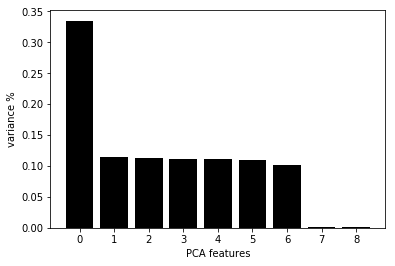

In [52]:
#PCA
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(X_train_numeric)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In [0]:
# Fit on training set only.
pca = PCA(n_components=7).fit(X_train_numeric)

# Apply transform to both the training set and the test set.
pca_train = pca.transform(X_train_numeric)
pca_test = pca.transform(X_test_numeric)

# Save components to a DataFrame
PCA_components_train = pd.DataFrame(pca_train)
PCA_components_test = pd.DataFrame(pca_test)

# Merge principal components with main dataframe
X_train = pd.concat([X_train, PCA_components_train], axis = 1)
X_test = pd.concat([X_test, PCA_components_test], axis = 1)

X_train.drop(numeric_features, axis = 1, inplace = True)
X_test.drop(numeric_features, axis = 1, inplace = True)

In [54]:
X_train.head()

,UniqueCarrier,Dest,0,1,2,3,4,5,6
0,19,145,-1.842993,-1.113948,0.434613,-0.454938,1.278217,-0.553451,-0.259644
1,15,258,3.526130,0.309585,-1.119633,1.295631,1.093328,1.170174,0.950072
2,12,140,-0.562339,-0.495220,2.007075,-2.368865,0.137840,0.946152,1.701975
3,9,240,-0.894405,-0.030087,-0.375182,-0.792488,-1.237432,2.109235,0.026197
4,19,57,-0.705803,1.938835,0.115941,-0.987849,-0.699430,-1.368748,0.127551


#### Naive Bayes

Default parameters

In [55]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    297860
           1       0.44      0.20      0.27     44931

    accuracy                           0.86    342791
   macro avg       0.66      0.58      0.60    342791
weighted avg       0.83      0.86      0.84    342791



#### Random Forest

Default parameters

In [0]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

Hyperparameter tuning

In [0]:
# n_estimators
n_estimators = [1, 5, 10, 15, 20, 25, 50]
test_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results)

In [0]:
# max_depths
max_depths = np.linspace(5, 35, 7)
test_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth = max_depth, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results)

**Final model**

Best parameters:
- n_estimators = 15
- max_depths = 25

In [0]:
model = RandomForestClassifier(n_estimators = 15, max_depth = 25, n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

### Feature selection

In [0]:
X_train = X_train_backup.copy()
X_test = X_test_backup.copy()

In [61]:
# RFE
from sklearn.feature_selection import RFE

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
rfe = RFE(estimator = model, n_features_to_select = None)
rfe = rfe.fit(X_train, y_train)

#Summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]

RuntimeError: ignored

In [0]:
# RFE
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = None)
rfe = rfe.fit(X_train, y_train)

#Summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
